## One-Dimensional Heat Equation

  The 1d heat equation is given by:

  del_u/del_t = alpha * (del_square_u/del_x_square)
  alpha = thermal diffusivity
  We need to enforce initial and boundary conditions:

  initial condition: u(x,0) = sin(pi*x)
  Boundary conditions: u(0,t) = and u(1,t) = 0

In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from torch.optim.lr_scheduler import StepLR

In [3]:
class PINN(nn.Module):
  def __init__(self):
    super().__init__()
    # self.layer1 = nn.Linear(in_features = 2, out_features=32)
    # self.layer2 = nn.Linear(in_features = 32, out_features=32)
    # self.layer3 = nn.Linear(in_features = 32, out_features=32)
    # self.layer4 = nn.Linear(in_features = 32, out_features=32)
    # self.layer5 = nn.Linear(in_features = 32, out_features=1)
    self.layer1 = nn.Linear(in_features = 2, out_features=20)
    self.layer2 = nn.Linear(in_features = 20, out_features=20)
    # self.layer3 = nn.Linear(in_features = 20, out_features=20)
    self.layer3 = nn.Linear(in_features = 20, out_features=1)
    self.ReLU = nn.ReLU()

  def forward(self,x):
    x = self.ReLU(self.layer1(x))
    x = self.ReLU(self.layer2(x))
    # x = self.ReLU(self.layer3(x))
    # x = self.ReLU(self.layer4(x))
    x = self.layer3(x)
    return x

In [4]:
model = PINN()

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
# scheduler = StepLR(optimizer, step_size=25000, gamma=0.1)
mse_loss = nn.MSELoss()

In [5]:
def loss_function(model, bc_points, u_bc, ic_points, u_ic, res_points):
  #Boundary Loss
  # print('BC')
  u_pred_bc = model(bc_points)
  bc_loss = mse_loss(u_pred_bc, u_bc)

  # Initial condition loss
  # print('IC')
  u_pred_ic = model(ic_points)
  ic_loss = mse_loss(u_pred_ic, u_ic)

  # Residual Loss
  # print('residual')
  # res_points.requires_grad=True

  # x_res = res_points[:, 0].requires_grad_(True)
  # # print('x_res requires grad: ', x_res.requires_grad)
  # t_res = res_points[:,1].requires_grad_(True)
  # # print('t_res requires grad: ', t_res.requires_grad)
  # # u_pred_res = model(torch.cat([x_res,t_res],dim=1))
  # u_pred_res = model(torch.cat([x_res, t_res], dim=1))
  x_res = res_points[:, 0:1].requires_grad_(True)
  t_res = res_points[:, 1:2].requires_grad_(True)
  u_pred_res = model(torch.cat([x_res, t_res], dim=1))

  u_t = torch.autograd.grad(u_pred_res, t_res, grad_outputs=torch.ones_like(u_pred_res), create_graph=True)[0]
  u_x = torch.autograd.grad(u_pred_res, x_res, grad_outputs=torch.ones_like(u_pred_res), create_graph=True)[0]
  u_xx = torch.autograd.grad(u_x, x_res, grad_outputs = torch.ones_like(u_x), create_graph=True)[0]

  res_loss = mse_loss(u_t,alpha*u_xx)

  return bc_loss+ic_loss + res_loss



In [6]:
alpha = 0.01 # Diffusion coefficient
L = 1.0      # Length of the domain
T = 1.0      # Total time

# Generate boundary condition data
N_bc = 50

In [7]:
x_bc = torch.cat([torch.zeros(N_bc//2,1), L*torch.ones(N_bc//2,1)], dim=0)
t_bc = torch.linspace(0,T, N_bc//2).view(-1,1)
t_bc = torch.concat([t_bc, t_bc], dim=0)

# u_bc = torch.zeros(N_bc,1)
u_bc = torch.full((N_bc,1),0,dtype=torch.float)

bc_points = torch.cat([x_bc,t_bc], dim=1)

In [8]:
# Generate Inital Conditions Data
N_ic = 50

# spatial coordinates for the initial condition
x_ic = torch.linspace(0,L,N_ic).view(-1,1)
t_ic = torch.zeros(N_ic,1)
u_ic = torch.sin(np.pi*x_ic)
ic_points = torch.cat([x_ic,t_ic],dim=1)


In [9]:
# Generate residual points
N_res = 10000
x_res = L*torch.rand(N_res,1)
t_res = T*torch.rand(N_res,1)
res_points = torch.cat([x_ic, t_ic], dim=1)

In [10]:
# combine all training data
all_x = torch.cat([x_bc, x_ic, x_res], dim=0)
all_t = torch.cat([t_bc, t_ic, t_res], dim=0)
all_u = torch.cat([u_bc,u_ic], dim=0)

In [11]:
epochs = 10000

for epoch in range(epochs):
  optimizer.zero_grad()
  loss = loss_function(model, bc_points, u_bc, ic_points, u_ic, res_points)
  loss.backward()
  optimizer.step()
  # scheduler.step()
  if epoch%1000==0:
    print(f'Epoch: {epoch} | Loss: {loss}')# | Learning Rate: {scheduler.get_last_lr()[0]}')

Epoch: 0 | Loss: 0.9003791809082031
Epoch: 1000 | Loss: 0.0002640632155817002
Epoch: 2000 | Loss: 0.00026893746689893305
Epoch: 3000 | Loss: 0.0002705545339267701
Epoch: 4000 | Loss: 0.00026273136609233916
Epoch: 5000 | Loss: 0.00030438389512710273
Epoch: 6000 | Loss: 0.0002627455978654325
Epoch: 7000 | Loss: 0.00026274469564668834
Epoch: 8000 | Loss: 0.0002784928656183183
Epoch: 9000 | Loss: 0.0002627708890940994


In [12]:
x_test = torch.linspace(0, L, 100)
t_test = torch.linspace(0, T, 100)
x_test, t_test = torch.meshgrid(x_test, t_test)
x_test = x_test.reshape(-1, 1)
t_test = t_test.reshape(-1, 1)
u_test = model(torch.cat([x_test, t_test], dim=1))
u_test = u_test.detach().numpy().reshape(100, 100)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


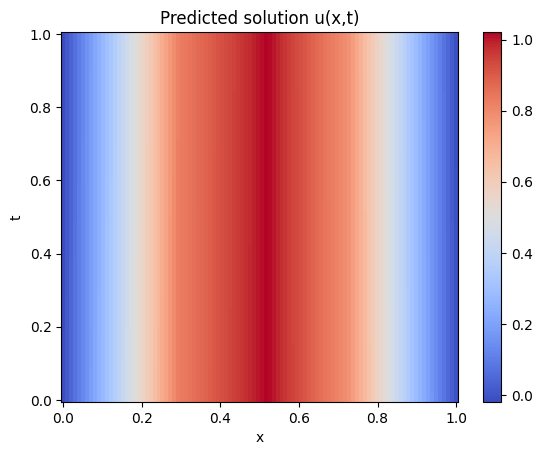

In [13]:
plt.figure()
plt.pcolormesh(x_test.reshape(100, 100), t_test.reshape(100, 100), u_test, cmap = cm.coolwarm)
plt.colorbar()
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted solution u(x,t)')
# plt.grid()
plt.show()

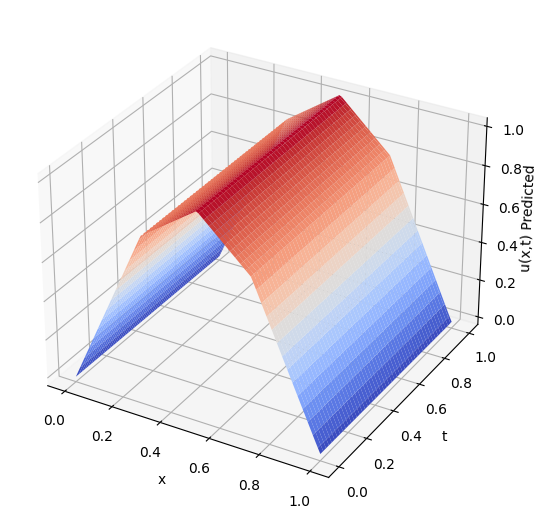

In [29]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# Creating figure
fig = plt.figure(figsize =(10, 8))
ax = plt.axes(projection ='3d')

# Creating plot
ax.plot_surface(x_test.reshape(100, 100), t_test.reshape(100, 100), u_test, cmap=cm.coolwarm)

ax.set_xlabel('x')

ax.set_ylabel('t')

ax.set_zlabel('u(x,t) Predicted', labelpad=-0.5)
plt.tight_layout()
plt.subplots_adjust(left=0, right=0.5, top=0.9, bottom=0.1)
# show plot
plt.show()